In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import streamlit as st

In [3]:
fires = pd.read_excel('Fires_100.xlsx')
fires = fires.dropna()



In [4]:
weatherdata = pd.read_csv('weatherdata.csv')
weatherdata = weatherdata.dropna()
weatherdata['Date'] = pd.to_datetime(weatherdata['Date'])
weatherdata['Date'] = weatherdata['Date'].dt.date

fires['ALARM_DATE'] = pd.to_datetime(fires['ALARM_DATE'])
fires['ALARM_DATE'] = fires['ALARM_DATE'].dt.date

In [5]:
print(fires.columns)
print(fires['UNIT_ID'].value_counts())
start_date = fires['ALARM_DATE'].min()
end_date = fires['ALARM_DATE'].max()

# Print the date range
print(f"Date range: {start_date} to {end_date}")

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE'],
      dtype='object')
UNIT_ID
Sonoma - Lake - Napa CAL FIRE       12
Fresno-Kings CAL FIRE               10
Modoc National Forest               10
Northern CA District - BLM          10
San Luis Obispo CAL FIRE             9
Madera - Mariposa CAL FIRE           9
Riverside CAL FIRE                   7
Klamath National Forest              6
San Diego CAL FIRE                   5
Sequoia National Forest              5
Los Angeles County                   5
Stanislaus National Forest           5
Nevada - Yuba - Placer CAL FIRE      4
Santa Barbara County                 4
Kern County                          4
Santa Clara CAL FIRE                 4
Amador - El Dorado CAL FIRE          4
Tuolumne - Calaveras CAL FIRE        4
Butte CAL FIRE                       3
San Bernardino CAL FIRE              3
San Be

In [6]:
cafires = fires[(fires["UNIT_ID"] == "San Luis Obispo CAL FIRE" )| # 93401 -- using zip codes to identify the fires
                (fires["UNIT_ID"] == "Orange County") | # 96006
                (fires["UNIT_ID"] == "Los Angeles County") | #90089
                (fires["UNIT_ID"] == "Sonoma - Lake - Napa CAL FIRE") | #93101
                (fires["UNIT_ID"] == "Fresno-Kings CAL FIRE") |# 93637
                (fires["UNIT_ID"] == "Ventura County")]

# cafires['UNIT_ID'] = cafires['UNIT_ID'].replace('San Luis Obispo CAL FIRE', 'San Luis Obispo')
# cafires['UNIT_ID'] = cafires['UNIT_ID'].replace('Sonoma - Lake - Napa CAL FIRE', 'Oakville')
# cafires['UNIT_ID'] = cafires['UNIT_ID'].replace('Fresno-Kings CAL FIRE', 'Fresno State')
# cafires['UNIT_ID'] = cafires['UNIT_ID'].replace('Ventura County', 'Moorpark')
# cafires['UNIT_ID'] = cafires['UNIT_ID'].replace('Orange County', 'Irvine')
# cafires['UNIT_ID'] = cafires['UNIT_ID'].replace('Los Angeles County', 'Santa Monica')
cafires.loc[:, 'UNIT_ID'] = cafires['UNIT_ID'].replace({
    'San Luis Obispo CAL FIRE': 'San Luis Obispo',
    'Sonoma - Lake - Napa CAL FIRE': 'Oakville',
    'Fresno-Kings CAL FIRE': 'Fresno State',
    'Ventura County': 'Moorpark',
    'Orange County': 'Irvine',
    'Los Angeles County': 'Santa Monica'
})


print(weatherdata['Stn Name'].unique())
print(cafires.head())

['San Luis Obispo' 'Irvine' 'Oakville' 'Fresno State' 'Santa Monica'
 'Moorpark']
    YEAR_       STATE                                             AGENCY  \
8    2017  California  California Department of Forestry and Fire Pro...   
9    2017  California  California Department of Forestry and Fire Pro...   
10   2017  California  California Department of Forestry and Fire Pro...   
11   2017  California  California Department of Forestry and Fire Pro...   
12   2017  California  California Department of Forestry and Fire Pro...   

            UNIT_ID FIRE_NAME  INC_NUM  ALARM_DATE  CONT_DATE  \
8   San Luis Obispo      LUCY     6548  2017-06-14 2017-06-14   
9   San Luis Obispo     OLIVE     8451  2017-07-24 2017-07-24   
10  San Luis Obispo     STONE     7792  2017-07-09 2017-07-11   
11  San Luis Obispo     ALAMO     7624  2017-07-06 2017-07-20   
12  San Luis Obispo      HILL     7101  2017-06-26 2017-06-30   

                CAUSE                                 COMMENTS REPORT_

In [7]:

# Create a set of fire dates for fast lookup
fire_date_sets = {
    "San Luis Obispo": set(cafires[cafires["UNIT_ID"] == "San Luis Obispo"]['ALARM_DATE']),
    "Oakville": set(cafires[cafires["UNIT_ID"] == "Oakville"]['ALARM_DATE']),
    "Fresno State": set(cafires[cafires["UNIT_ID"] == "Fresno State"]['ALARM_DATE']),
    "Moorpark": set(cafires[cafires["UNIT_ID"] == "Moorpark"]['ALARM_DATE']),
    "Irvine": set(cafires[cafires["UNIT_ID"] == "Irvine"]['ALARM_DATE']),
    "Santa Monica": set(cafires[cafires["UNIT_ID"] == "Santa Monica"]['ALARM_DATE'])
}


# Function to check if fire occurred based on county and date
def fire_occurred(row):
    county = row['Stn Name']
    date = row['Date']
    
    if county in fire_date_sets and date in fire_date_sets[county]:
        return 1
    return 0

# Apply function to determine fire occurrence
weatherdata['FireOccurred'] = weatherdata.apply(fire_occurred, axis=1)

# Print the updated DataFrame
print(weatherdata.head())

   Stn Id         Stn Name           CIMIS Region        Date  Jul  ETo (in)  \
0      52  San Luis Obispo  Central Coast Valleys  2017-04-01   91      0.18   
1      52  San Luis Obispo  Central Coast Valleys  2017-04-02   92      0.16   
2      52  San Luis Obispo  Central Coast Valleys  2017-04-03   93      0.16   
3      52  San Luis Obispo  Central Coast Valleys  2017-04-04   94      0.17   
4      52  San Luis Obispo  Central Coast Valleys  2017-04-05   95      0.18   

  qc  Precip (in) qc.1  Sol Rad (Ly/day)  ... qc.9  Dew Point (F) qc.10  \
0             0.0                  552.0  ...                44.7         
1             0.0                  560.0  ...                52.7         
2             0.0                  541.0  ...                52.6         
3             0.0                  553.0  ...                48.5         
4             0.0                  547.0  ...                50.0         

   Avg Wind Speed (mph) qc.11  Wind Run (miles) qc.12  Avg Soil Temp

In [8]:
X = weatherdata[['Precip (in)', 'Max Air Temp (F)', 'Min Air Temp (F)', 'Avg Rel Hum (%)', 'Avg Wind Speed (mph)', 
                 'Dew Point (F)']]
Y = weatherdata['FireOccurred']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [9]:
# Initialize model
model = LogisticRegression()

# Train the model
model.fit(X_train, Y_train)

# Print the logistic regression equation
intercept = model.intercept_[0]  # Intercept (bias)
coefficients = model.coef_[0]   # Coefficients for each feature

# Feature names (assuming 'X' is your features DataFrame)
feature_names = X.columns

# Construct the equation
equation = f"Logistic Regression Equation: log(P/1-P) = {intercept:.4f}"
for i in range(len(coefficients)):
    equation += f" + ({coefficients[i]:.4f}) * {feature_names[i]}"

print(equation)



Logistic Regression Equation: log(P/1-P) = -5.2191 + (-0.7019) * Precip (in) + (0.8128) * Max Air Temp (F) + (-0.0624) * Min Air Temp (F) + (-0.3607) * Avg Rel Hum (%) + (0.3915) * Avg Wind Speed (mph) + (0.2221) * Dew Point (F)


In [10]:

from sklearn.metrics import accuracy_score, classification_report

# Predict on test set
y_pred = model.predict(X_test)

# Check accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Print detailed performance metrics
print(classification_report(Y_test, y_pred))



Model Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       469
           1       0.00      0.00      0.00         9

    accuracy                           0.98       478
   macro avg       0.49      0.50      0.50       478
weighted avg       0.96      0.98      0.97       478



c:\Users\Ellis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ellis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ellis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:

# if you input test data, do 
data=[[50, 0, 0, 0, 0, 0]]

prediction = model.predict(data)

if prediction[0] == 1:
    print("Fire will occur")
else:
    print("Fire will not occur")

Fire will not occur


### graphs

31   2017-05-02
44   2017-05-15
74   2017-06-14
86   2017-06-26
96   2017-07-06
Name: Date, dtype: datetime64[ns]
31    89.0
44    61.9
74    83.8
86    86.8
96    86.5
Name: Max Air Temp (F), dtype: float64


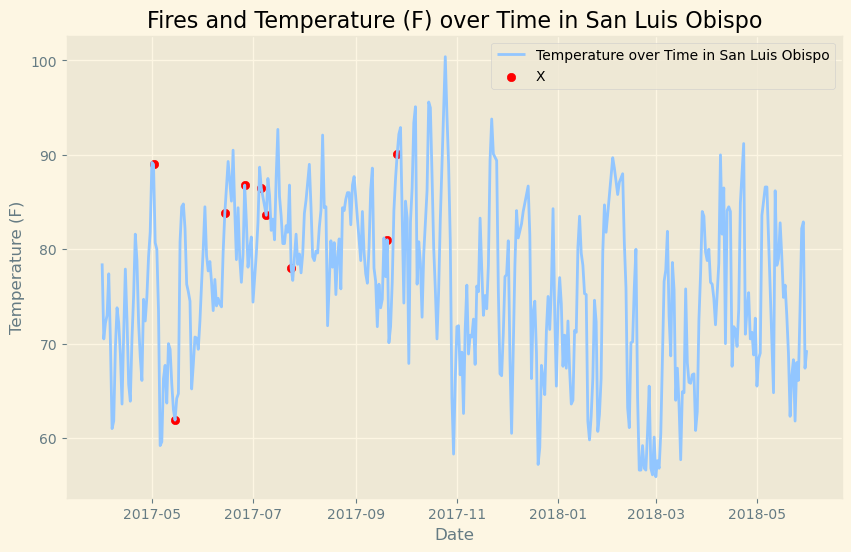

948    2017-07-06
984    2017-08-11
1036   2017-10-02
1042   2017-10-08
1043   2017-10-09
Name: Date, dtype: datetime64[ns]
948     99.1
984     85.5
1036    82.5
1042    84.0
1043    82.7
Name: Max Air Temp (F), dtype: float64


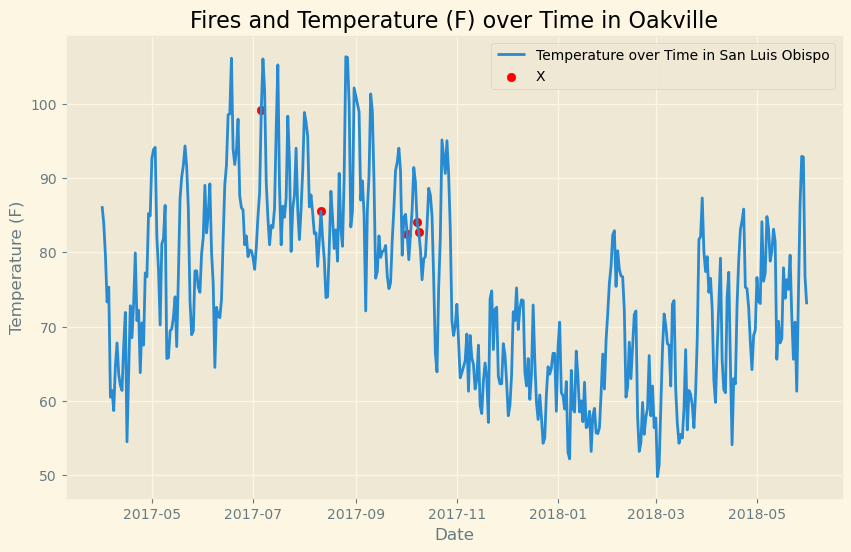

2377   2017-12-04
Name: Date, dtype: datetime64[ns]
2377    0.03
Name: Precip (in), dtype: float64


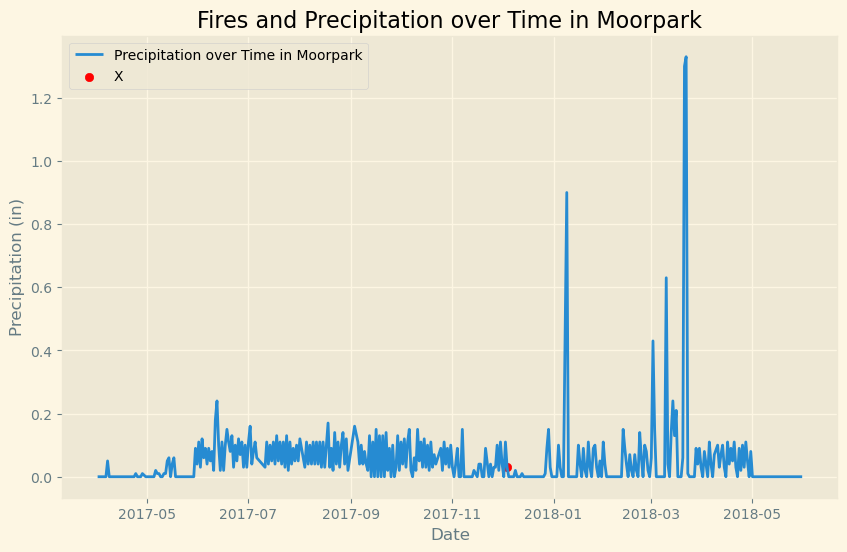

In [42]:
import matplotlib.pyplot as plt
from matplotlib import style
weatherdata['Date'] = pd.to_datetime(weatherdata['Date'])

slo_weather = weatherdata[weatherdata["Stn Name"] == "San Luis Obispo"].sort_values("Date")
plt.figure(figsize=(10, 6))
plt.plot(slo_weather["Date"], slo_weather["Max Air Temp (F)"], label="Temperature over Time in San Luis Obispo")
slo_fires = slo_weather.loc[slo_weather['FireOccurred'] == 1, 'Date']
slo_fires_temps = slo_weather[slo_weather['FireOccurred']==1]['Max Air Temp (F)']

plt.scatter(slo_fires, slo_fires_temps, color='red', label='X')
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.style.use('Solarize_Light2')


plt.title("Fires and Temperature (F) over Time in San Luis Obispo")
plt.grid(True)
plt.legend()

print(slo_fires.head())
print(slo_fires_temps.head())

plt.show()



oakville_weather = weatherdata[weatherdata["Stn Name"] == "Oakville"].sort_values("Date")
plt.figure(figsize=(10, 6))
plt.plot(oakville_weather["Date"], oakville_weather["Max Air Temp (F)"], label="Temperature over Time in San Luis Obispo")
slo_fires = oakville_weather.loc[oakville_weather['FireOccurred'] == 1, 'Date']
slo_fires_temps = oakville_weather[oakville_weather['FireOccurred']==1]['Max Air Temp (F)']

plt.scatter(slo_fires, slo_fires_temps, color='red', label='X')
plt.xlabel("Date")
plt.style.use('Solarize_Light2')
plt.ylabel("Temperature (F)")

plt.title("Fires and Temperature (F) over Time in Oakville")
plt.grid(True)
plt.legend()

print(slo_fires.head())
print(slo_fires_temps.head())

plt.show()




slo_weather = weatherdata[weatherdata["Stn Name"] == "Moorpark"].sort_values("Date")
plt.figure(figsize=(10, 6))
plt.plot(slo_weather["Date"], slo_weather["Precip (in)"], label="Precipitation over Time in Moorpark")
slo_fires = slo_weather.loc[slo_weather['FireOccurred'] == 1, 'Date']
slo_fires_temps = slo_weather[slo_weather['FireOccurred']==1]['Precip (in)']

plt.scatter(slo_fires, slo_fires_temps, color='red', label='X')
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.style.use('seaborn-v0_8-pastel')

plt.title("Fires and Precipitation over Time in Moorpark")
plt.grid(True)
plt.legend()

print(slo_fires.head())
print(slo_fires_temps.head())

plt.show()


